In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
markup = pd.read_json('/content/drive/MyDrive/manipulation_markup/markup_final.json', lines=True)

##DATASET

In [ ]:
manipulations = []
man_label = []

for i in range(len(markup)):
  text = markup['input_input'].iloc[i]
  for man in markup['output_result'].iloc[i]:
    manipulations.append(text[man['start']:man['end']+1])
    man_label.append(man['class_name'])


man_dataframe = pd.DataFrame()
man_dataframe['manipulation'] = pd.Series(manipulations)
man_dataframe['label'] = pd.Series(man_label)

In [ ]:
len(man_dataframe)

9795

In [ ]:
labels = man_dataframe['label'].unique()
label_ids = []
for i in range(len(man_dataframe)):
  for j, label_name in enumerate(labels):
    if man_dataframe['label'].iloc[i] == label_name:
      label_ids.append(j)

man_dataframe['label_id'] = pd.Series(label_ids)

In [ ]:
import re

In [ ]:
big_label = []
for i in range(len(man_dataframe)):
  big_label.append(re.search('\(\S+\)', man_dataframe['label'].iloc[i]).group(0))

man_dataframe['big_label'] = pd.Series(big_label)

big_labels = man_dataframe['big_label'].unique()
big_label_ids = []
for i in range(len(man_dataframe)):
  for j, big_label_name in enumerate(big_labels):
    if man_dataframe['big_label'].iloc[i] == big_label_name:
      big_label_ids.append(j)

man_dataframe['big_label_id'] = pd.Series(big_label_ids)


In [ ]:
man_dataframe

,manipulation,label,label_id,big_label,big_label_id
0,Переговоры лидеров Р,Прием маскировки под ссылку на авторитет (деав...,0,(деавторизация),0
1,,Прием маскировки под ссылку на авторитет (деав...,0,(деавторизация),0
2,"асштабности, но и по уровню оснащенности медиц...",Позитивирующая гиперболизация (позитивизация),1,(позитивизация),1
3,азания медицинской помощи,Лозунговые слова и словосочетания (позитивизация),2,(позитивизация),1
4,тчислений могут получить россияне «После индек...,Прием «после этого не значит поэтому» (паралог...,3,(паралогизация),2
...,...,...,...,...,...
9790,сковский гарнизонный военный суд приговорил фи...,Вкрапление депрессивов (негативизация),15,(негативизация),3
9791,начала года в Альметьевском районе произошло 7...,Вкрапление депрессивов (негативизация),15,(негативизация),3
9792,С начала года на территории Альметьевского рай...,Вкрапление депрессивов (негативизация),15,(негативизация),3
9793,"В них погибло 10 человек, еще 14 получили ране...",Вкрапление депрессивов (негативизация),15,(негативизация),3


In [ ]:
man_dataframe['label'].unique()

array(['Прием маскировки под ссылку на авторитет (деавторизация)',
       'Позитивирующая гиперболизация (позитивизация)',
       'Лозунговые слова и словосочетания (позитивизация)',
       'Прием «после этого не значит поэтому» (паралогизация)',
       'Прием моделирования негативного сценария (негативизация)',
       'Эвфемизация (позитивизация)',
       'Навешивание ярлыков (негативизация)',
       'Ссылки на неопределенный источник (деавторизация)',
       'Подмена тезиса (паралогизация)', 'Дисфемизмы (негативизация)',
       'Ложное причинно-следственное моделирование (паралогизация)',
       'Негативирующая гиперболизация (негативизация)',
       'Прием обесценивания (негативизация)',
       'Ссылки на свидетельства участников и очевидцев событий, имена и фамилии которых не называются (деавторизация)',
       'Высказывание о состоянии другого (паралогизация)',
       'Вкрапление депрессивов (негативизация)',
       'Поставка мишени в один ряд с негативно оцениваемым объектом (нег

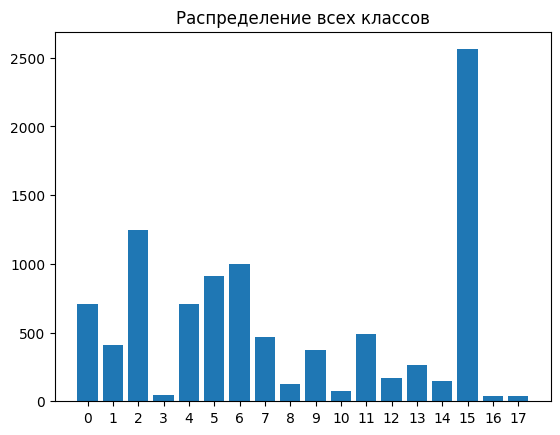

In [ ]:
ids = man_dataframe.groupby(['label_id']).count().index
groups = [str(idx) for idx in ids]
counts = man_dataframe.groupby(['label_id']).count()['label']

plt.bar(groups, counts)
plt.title('Распределение всех классов')
plt.show()

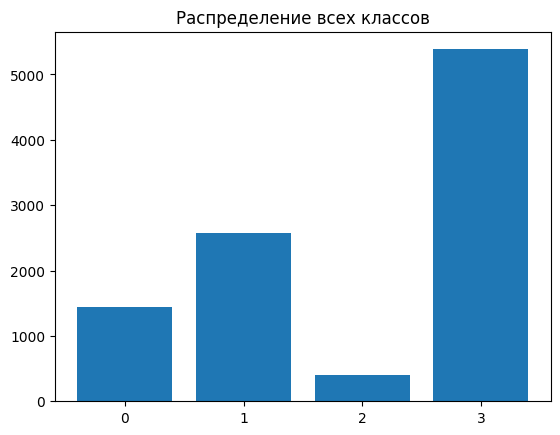

In [ ]:
ids = man_dataframe.groupby(['big_label_id']).count().index
groups = [str(idx) for idx in ids]
counts = man_dataframe.groupby(['big_label_id']).count()['big_label']

plt.bar(groups, counts)
plt.title('Распределение всех классов')
plt.show()

In [ ]:
class_counts = man_dataframe.groupby(['label_id']).count()['label'].values
data_len = class_counts.sum()
class_weights = [float(num/data_len) if num>500 else 1.0 for num in class_counts]

big_class_counts = man_dataframe.groupby(['big_label_id']).count()['big_label'].values
big_class_weights = [float(num/data_len) if num>500 else 1.0 for num in big_class_counts]

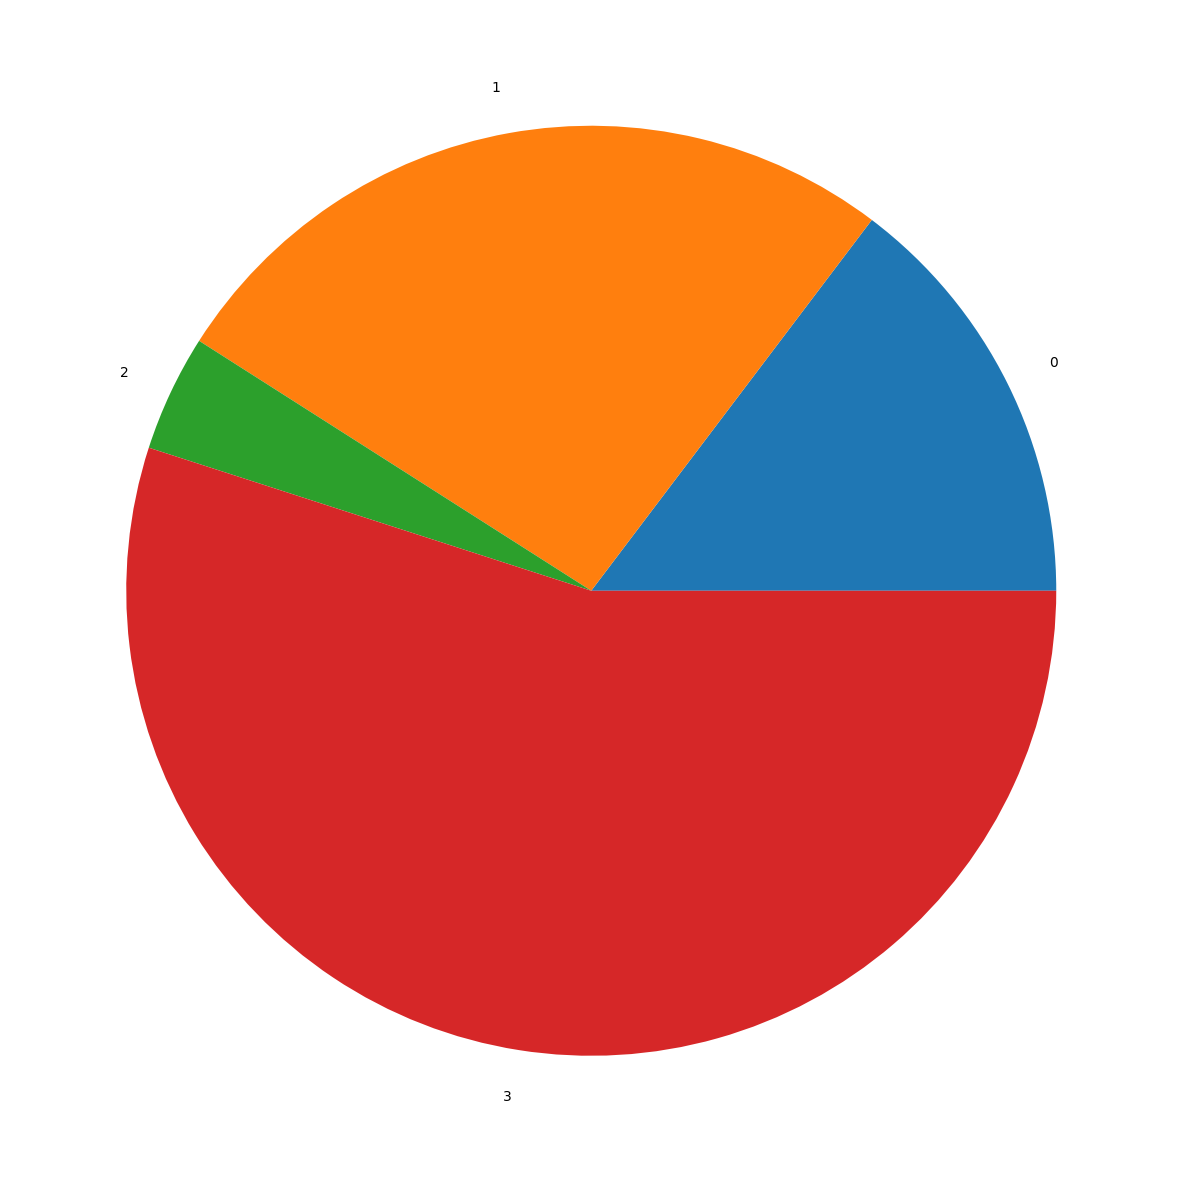

In [ ]:
vals = counts
labels = groups
fig, ax = plt.subplots()
ax.pie(vals, labels=labels)
fig.set_size_inches(15, 20)
plt.show()

##Eng data

In [ ]:
import os
import re

In [ ]:
eng_man_dataframe = pd.DataFrame()
eng_label = []
eng_man = []

for filename in os.listdir('/content/drive/MyDrive/eng_data/train'):
  if filename.endswith('.tsv'):
    idx = re.search('\d+', filename).group(0)
    text  = open(f'/content/drive/MyDrive/eng_data/train/article{idx}.txt', 'r').read()
    try:
      spans = pd.read_table(f'/content/drive/MyDrive/eng_data/train/{filename}', header=None)
    except:
      continue

    for i in range(len(spans)):
      eng_man.append(text[spans[2].iloc[i]:spans[3].iloc[i]+1])
      eng_label.append(spans[1].iloc[i])

eng_man_dataframe['manipulation'] = pd.Series(eng_man)
eng_man_dataframe['label'] = pd.Series(eng_label)

In [ ]:
labels = eng_man_dataframe['label'].unique()
label_ids = []
for i in range(len(eng_man_dataframe)):
  for j, label_name in enumerate(labels):
    if eng_man_dataframe['label'].iloc[i] == label_name:
      label_ids.append(j)

eng_man_dataframe['label_id'] = pd.Series(label_ids)

In [ ]:
eng_man_dataframe

,manipulation,label,label_id
0,Make America Great Again),Slogans,0
1,Make American Great Again”,Slogans,0
2,tch ass motherf**ker.”\n,Loaded_Language,1
3,ump supporter’s f,Repetition,2
4,MAGA,Slogans,0
...,...,...,...
5109,the CIA steadfastly kept secret from the Ameri...,Flag-Waving,5
5110,Every American owes it to himself to read that...,Flag-Waving,5
5111,to keep some of the CIA’s decades-old JFK’s re...,Flag-Waving,5
5112,"lone nut former U.S. Marine communist,","Name_Calling,Labeling",3


##Dataset

In [ ]:
train_data, val_data = train_test_split(man_dataframe[['manipulation','label_id']], test_size=0.2, shuffle=True)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-base-cased-nli-twoway")

In [ ]:
encod_text_train = tokenizer.batch_encode_plus(train_data['manipulation'], return_tensors='pt', truncation=True, padding = 'max_length', max_length = 50)
encod_text_val = tokenizer.batch_encode_plus(val_data['manipulation'], return_tensors='pt', truncation=True, padding = 'max_length', max_length = 50)

In [ ]:
labels_train = torch.tensor((train_data['label_id'].values))
labels_val = torch.tensor((val_data['label_id'].values))

In [ ]:
train_seq = encod_text_train['input_ids']
train_mask = encod_text_train['attention_mask']

val_seq = encod_text_val['input_ids']
val_mask = encod_text_val['attention_mask']

In [ ]:
train_seq.shape

torch.Size([7836, 50])

In [ ]:
train_data = TensorDataset(train_seq, train_mask, labels_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = 200)

val_data = TensorDataset(val_seq, val_mask, labels_val)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = 200)

##Model

In [ ]:
import torch, torch.nn as nn

In [ ]:
from transformers import AutoModel
bert = AutoModel.from_pretrained("cointegrated/rubert-base-cased-nli-twoway")

Some weights of the model checkpoint at cointegrated/rubert-base-cased-nli-twoway were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for param in bert.parameters():
 param.requires_grad = False

In [ ]:
class rubert_cls(nn.Module):
    
    def __init__(self, bert):
        super(rubert_cls, self).__init__()
        self.bert = bert
        self.drop1 = nn.Dropout(0.3)
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()
        self.relu3 = nn.LeakyReLU()
        self.sig = nn.Sigmoid()
        self.fc1 = nn.Linear(768,150)
        self.fc2 = nn.Linear(150,18)
    
    def forward(self, sent_id, mask):
        _, bert_out = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.relu1(bert_out)
        x = self.drop1(x)
        x = self.relu2(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = rubert_cls(bert)
model.load_state_dict(torch.load('/content/drive/MyDrive/manipulation_cls18_2fc_engdata.pt'))
model = model.to(device)

##Training

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),
                 lr = 1e-2)

In [ ]:
#sc=torch.tensor(big_class_weights).to(device)

In [ ]:
loss_f = nn.CrossEntropyLoss()

In [ ]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = loss_f(preds, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

In [ ]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_labels = []
    correct = 0
    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            _, preds_label = torch.max(preds, 1)
            
            correct += (preds_label == labels).sum().item()
            
            loss = loss_f(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels.detach().cpu().numpy())
    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds, total_labels

In [ ]:
#train_losses=[]
#valid_losses=[]

In [ ]:
epochs = 5
for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, _ = train()
    valid_loss, preds, labels = evaluate()
    preds = torch.tensor(preds)
    _, val_idx = torch.max(preds, 1)
    lablz = []
    for arr in labels:
      for a in arr:
        lablz.append(a)

    #if valid_loss < best_valid_loss:
       # best_valid_loss = valid_loss
        #torch.save(model.state_dict(), f'/content/drive/MyDrive/atemp_100f1_dip.pt') 
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    #f_1.append(f1_score(val_idx, lablz))
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    #print('acc = ', accuracy_score(val_idx, lablz))
    #print('rec = ', recall_score(val_idx, lablz))
    #print('pr = ', precision_score(val_idx, lablz))
    #print('f1 = ', f1_score(val_idx, lablz))


 Epoch1 / 5


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]



Training loss: 5.113
Validation loss: 3.226

 Epoch2 / 5


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]



Training loss: 3.703
Validation loss: 3.149

 Epoch3 / 5


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]



Training loss: 3.594
Validation loss: 2.990

 Epoch4 / 5


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]



Training loss: 3.582
Validation loss: 2.988

 Epoch5 / 5


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Training loss: 3.461
Validation loss: 3.074


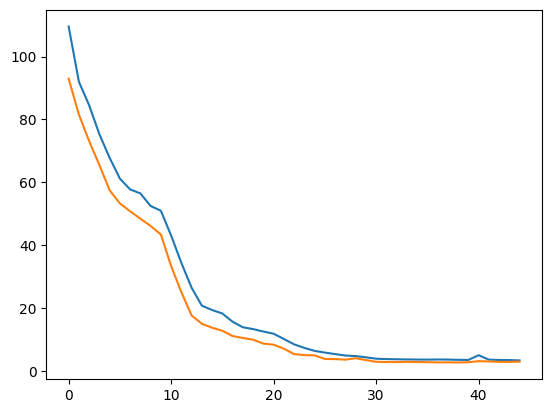

In [ ]:
plt.plot(train_losses)
plt.plot(valid_losses)

##Test


In [ ]:
def testing():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_labels = []
    correct = 0
    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            _, preds_label = torch.max(preds, 1)
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels.detach().cpu().numpy())
    total_preds = np.concatenate(total_preds, axis = 0)

    return total_preds, total_labels

In [ ]:
pred_test, labl = testing()
pred_test = torch.tensor(pred_test)
_, test_idx = torch.max(pred_test, 1)

100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


In [ ]:
lablz = []
for arr in labl:
  for a in arr:
    lablz.append(a)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [ ]:
acc = accuracy_score(test_idx, lablz)
rec = recall_score(test_idx, lablz, average = 'micro')
pr = precision_score(test_idx, lablz, average = 'micro')

In [ ]:
print(acc)
print(rec)
print(pr)

0.28024502297090353
0.28024502297090353
0.28024502297090353
